In [1]:
!git clone https://github.com/RDLigeralde/cond_dist_flow.git

Cloning into 'cond_dist_flow'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 14 (delta 1), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (14/14), 56.96 KiB | 857.00 KiB/s, done.
Resolving deltas: 100% (1/1), done.


In [2]:
from google.colab import files

#For using external files

import jax
from jax import grad, jit, vmap, jacfwd
import jax.numpy as jnp
import jax.numpy.linalg as jla
from functools import partial

import scipy
import numpy as np

import numpy.matlib
import matplotlib.pyplot as plt

import time

import cond_dist_flow.kernels as ks
import cond_dist_flow.generate_params as gps
import cond_dist_flow.sample_points as sps
import cond_dist_flow.plot_tools as pts

In [3]:
# define dataset
N = 500
M = 20 * N
LM = True
ystr = 1

data_array = sps.sample_moon(N, M, LM, ystr)
Zinitial = data_array[0]
Zcurrent = data_array[1]
Zjoint = data_array[2]

if LM:
  Zlm = data_array[3]

In [ ]:

"""
Parameters for gradient flow
Currently picking bounds for learning rates and bandwidths is extremely finnicky (easy to get NaNs)
Planning to introduce gradient clipping to avoid this
"""

#Choose kernel and bandwidth selector
RHS = ks.RHS_poly
d = gps.dists

maxIter = 3_000 # number of flow iterations
max_lr = .25
min_lr = .1
lrs = gps.make_lrs(Zcurrent, Zjoint, min_lr, max_lr) # nearest-neighbor based local learning rate

#If SGD true, then only use Msub, Nsub points
SGD = False
Msub = int(M/5); Nsub = int(N/4)



#For bandwidth selections: # of neighbor points, bandwidth range
neighbors_product = 25
neighbors_joint = 15
min_bw = .1
max_bw = .125

#Determines how many iterations between bandwidth refreshes
refresh_rate = 100

#Create triangular cost
lam = 10_000
lamMat = gps.make_lambda(lam, 1, 1)

#Minimum and maximum values for gradient clipping
grad_min = -lam
grad_max = lam

if SGD:
  Zcr = Zcurrent[np.random.choice(M, size = Msub, replace = False, p = None),:]
  Zjnt = Zjoint[np.random.choice(N, size = Nsub, replace = False, p = None),:]

  bw = d(Zcr, neighbors_product, min_bw, max_bw)
  bwtar = d(Zjoint, neighbors_joint, min_bw, max_bw)
else:
  bw = d(Zcurrent, neighbors_product, min_bw, max_bw)
  bwtar = d(Zjoint, neighbors_joint, min_bw, max_bw)


In [ ]:
"""
Main Loop Basis
JIT Breaks this for some reason
"""

def single_iter(Zcr, bw, lrs):

  G = RHS(Zcr, Zcurrent, Zjoint, bw, bwtar)
  G_tri = jnp.matmul(lamMat, G).T
  G_clip = jnp.clip(G_tri, grad_min, grad_max)

  return Zcr - lrs * G_clip

single_iters = vmap(single_iter, in_axes = (0, 0, None))

In [ ]:
"""
Simple Main Loop
"""

now = time.time()

for i in range(maxIter):

  if (i % refresh_rate) == 0:
    bw = d(Zcurrent, neighbors_product, min_bw, max_bw)
    lrs = gps.make_lrs(Zcurrent, Zjoint, min_lr, max_lr)

  Zcurrent = single_iter(Zcurrent, bw, lrs)

t = jnp.round(time.time() - now, 2)
print('Execution time =', t)

Execution time = 22.59


In [ ]:
"""
Main Loop with integrated LMs
"""

now = time.time()

for i in range(maxIter):

  if (i % refresh_rate) == 0:
    bw = d(Zcurrent, neighbors_product, min_bw, max_bw)
    bw_lm = d(Zlm, neighbors_product, min_bw, max_bw)
    lrs = gps.make_lrs(Zcurrent, Zjoint, min_lr, max_lr)

  Zlm = single_iter(Zlm, bw_lm, lrs)
  Zcurrent = single_iter(Zcurrent, bw, lrs)

t = jnp.round(time.time() - now, 2)
print('Execution time =', t)

Execution time = 147.95999


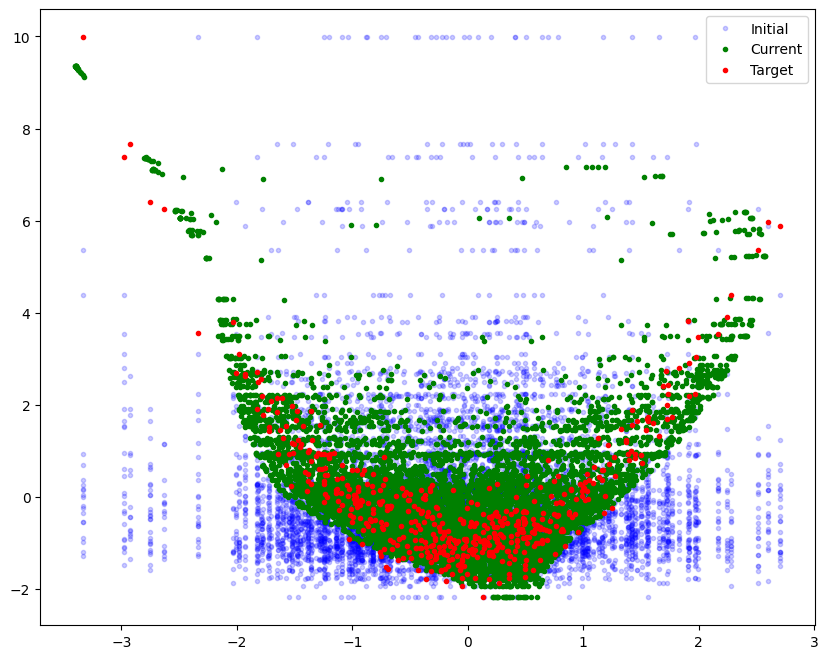

In [ ]:
#For plot saving
info = [RHS.__name__, str(maxIter), str(min_bw) + " to " + str(max_bw), str(min_lr) + " to " + str(max_lr), str(neighbors_product), str(refresh_rate), "ss"]
save = False
pts.make_plot(info, save, Zinitial, Zcurrent, Zjoint)

Mean movement in the y direction 0.009258053


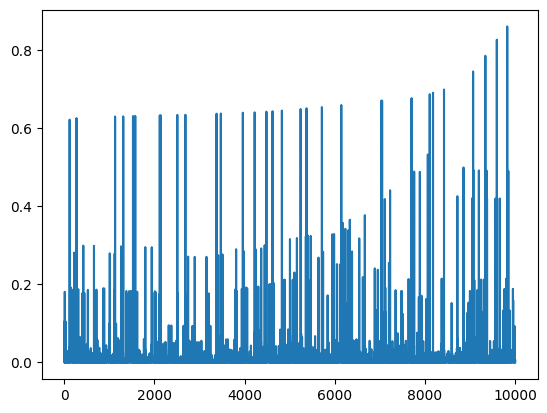

In [ ]:
pts.y_mvmt(Zcurrent, Zinitial)

In [ ]:
#Estimate with Lagrangia markers
#Check the estimated conditional density rho(x|ystr)
pts.LM_est(ystr)

TypeError: ignored